In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cmcrameri import cm

In [2]:
## Import full enrichment results
data_dir = r"C:\Users\neil_\DellXPS_June2024\OneDrive\Desktop\New UHN\Precision Medicine\carotid_plaque\workflow\pathway_enrichment\\"
kegg_permod = pd.read_csv(data_dir+"permod_KEGG.csv")
go_permod = pd.read_csv(data_dir+"permod_GO.csv")

for df in [kegg_permod, go_permod]:
    df.drop(columns=["Unnamed: 0", "module"], inplace=True)
    df.rename(columns={"Term": "pathway",
                       "Adjusted P-value":"q-value",
                       "Fold_Enrichment":"fold_enrichment"},
    inplace=True)

In [3]:
## Import filtered lists (filtered by SR)
data_dir = r"C:\Users\neil_\DellXPS_June2024\OneDrive\Desktop\New UHN\Precision Medicine\carotid_plaque\data\filtered_lists\\"
kegg_top = pd.read_csv(data_dir+"permod_kegg_top.txt", sep="\t", header=None) # NP removed redundant pathways "Longevity regulating pathway - multiple species", "Apoptosis - multiple species"
kegg_ec =  pd.read_csv(data_dir+"permod_kegg_ec.txt", sep="\t", header=None)

go_top = pd.read_csv(data_dir+"permod_go_top.txt", sep="\t", header=None)
go_ec =  pd.read_csv(data_dir+"permod_go_ec.txt", sep="\t", header=None)

In [4]:
class Enrichment:
    def __init__(self, db, all_df, top_df, ec_df):
        self.database = db
        self.enrichment_df = all_df
        self.top_pathways = list(set(top_df[0]))
        self.endo_pathways = list(set(ec_df[0]))

In [5]:
GO_permod = Enrichment("GO BP", go_permod, go_top, go_ec)
KEGG_permod = Enrichment("KEGG", kegg_permod, kegg_top, kegg_ec)

In [6]:
def get_top_df(full_df, top_pthwys):
    filtered_df = full_df[full_df["pathway"].isin(top_pthwys)]
    return filtered_df

In [7]:
def remove_duplicates_by_cohort(filtered_df):
    # Drop duplicates per cohort after sorting by fold_enrichment
    symp_df = filtered_df[filtered_df["cohort"] == "symptomatic"].sort_values(by="fold_enrichment", ascending=False).drop_duplicates(subset="pathway")
    asymp_df = filtered_df[filtered_df["cohort"] == "asymptomatic"].sort_values(by="fold_enrichment", ascending=False).drop_duplicates(subset="pathway")

    filtered_df = pd.concat([symp_df, asymp_df])
    return filtered_df
    

In [8]:
def get_pivot_df(filtered_df):
    pivot_df = filtered_df.pivot_table(index='pathway', columns='cohort', values='fold_enrichment')
    # Ensure 'symptomatic' and 'asymptomatic' columns exist with default values set to 1.0 if they don't
    if 'symptomatic' not in pivot_df.columns:
        pivot_df['symptomatic'] = np.nan
    if 'asymptomatic' not in pivot_df.columns:
        pivot_df['asymptomatic'] = np.nan
    
    # Reorder columns to ensure 'symptomatic' and 'asymptomatic' are in the right place if needed
    pivot_df = pivot_df[['asymptomatic', 'symptomatic']]

    pivot_df.fillna(1.0, inplace=True)
    return pivot_df

In [9]:
def filter_pivot_by_variation(pivot_df, n=30):
    variation = pivot_df.std(axis=1)
    top_n_labels = variation.nlargest(n).index
    filtered_pivot = pivot_df.loc[top_n_labels]
    return filtered_pivot

In [10]:
for Enr in [GO_permod, KEGG_permod]:
    full_df = Enr.enrichment_df
    top_pthwys = Enr.top_pathways
    # Only include pathways specified by SR
    filtered_df = get_top_df(full_df, top_pthwys)
    Enr.filtered_df = remove_duplicates_by_cohort(filtered_df)
    pivot_df = get_pivot_df(Enr.filtered_df)
    Enr.pivot_df = filter_pivot_by_variation(pivot_df)

## GO

In [11]:
def format_go_bp_label(go_bp_label):
    new_label = go_bp_label.split("(GO:")[0].rstrip()
    return new_label

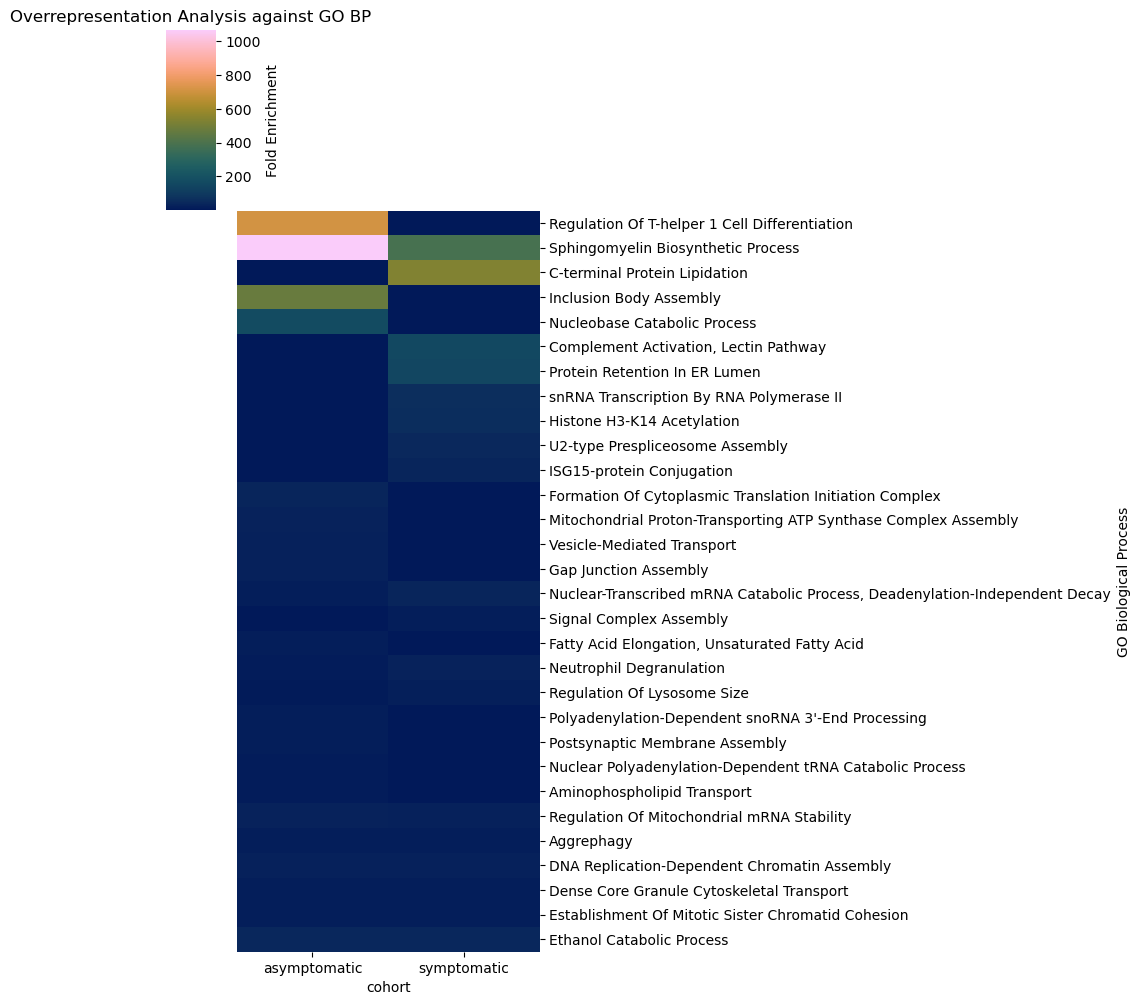

In [12]:
Enr = GO_permod
db = Enr.database
pivot_df = Enr.pivot_df.reset_index()
pivot_df["pathway"] = pivot_df["pathway"].apply(format_go_bp_label)
pivot_df.set_index("pathway", inplace=True)
pivot_df = pivot_df.rename_axis("GO Biological Process")

f = sns.clustermap(pivot_df,cmap=cm.batlow, figsize=(10, 10), annot=False, row_cluster=False, col_cluster=False)
plt.title(f'Overrepresentation Analysis against {db}')
plt.ylabel('Fold Enrichment')

f.savefig(f"permod_go_heatmap.pdf")
plt.show()

In [13]:
Enr.filtered_df

,pathway,q-value,fold_enrichment,cohort
122,Regulation Of Hepatocyte Proliferation (GO:200...,2.846111e-02,608.628571,symptomatic
116,C-terminal Protein Lipidation (GO:0006501),2.339896e-02,532.550000,symptomatic
120,Regulation Of Endothelial Cell Differentiation...,4.575242e-06,499.265625,symptomatic
109,Sphingomyelin Biosynthetic Process (GO:0006686),1.556115e-03,387.309091,symptomatic
84,"Complement Activation, Lectin Pathway (GO:0001...",3.212822e-08,156.632353,symptomatic
...,...,...,...,...
57,Aminophospholipid Transport (GO:0015917),1.187206e-02,10.131748,asymptomatic
20,Zinc Ion Import Into Organelle (GO:0062111),1.881107e-04,7.734931,asymptomatic
70,Intermediate Filament Organization (GO:0045109),9.832702e-15,6.450753,asymptomatic
25,Regulation Of Lysosome Size (GO:0062196),9.946107e-03,6.197847,asymptomatic


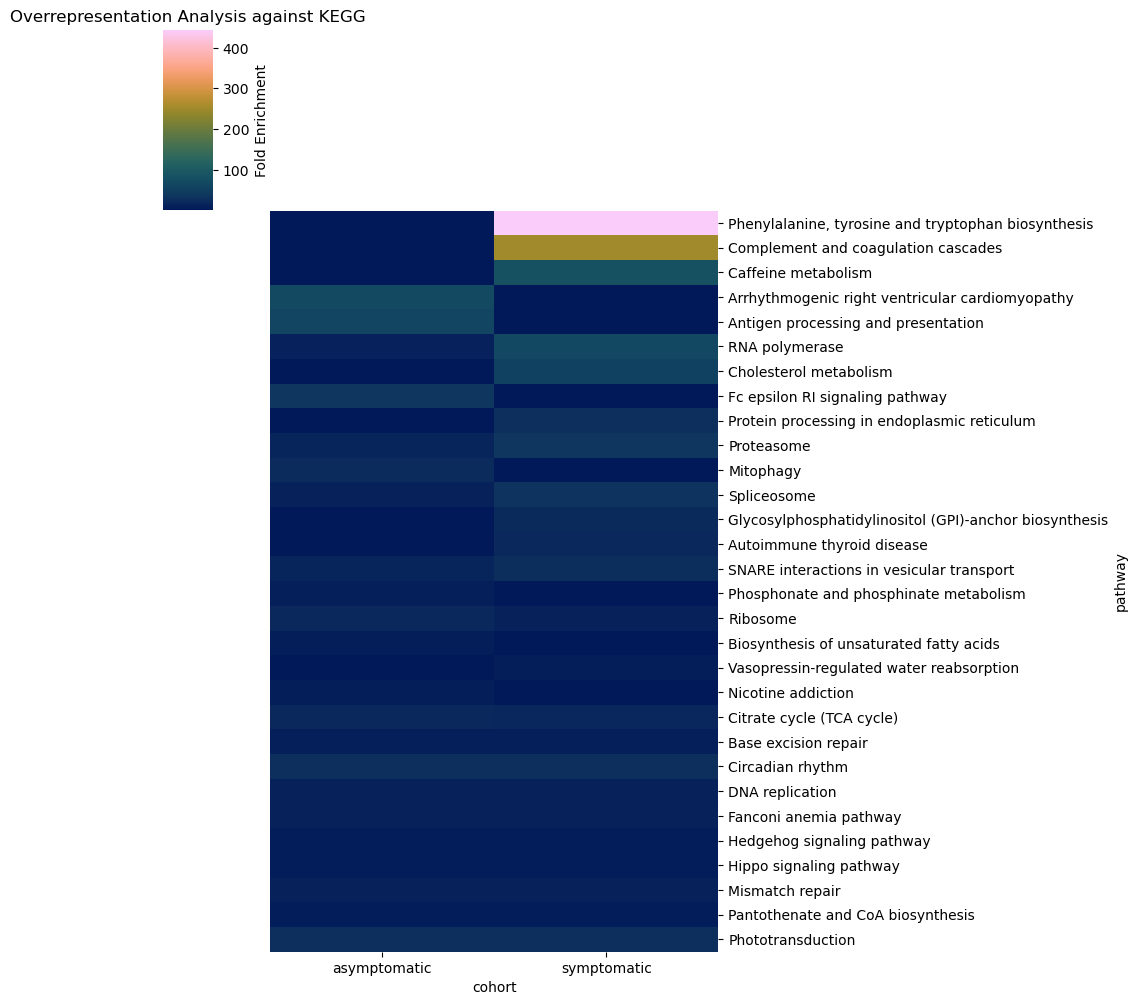

In [14]:
Enr = KEGG_permod
db = Enr.database
pivot_df = Enr.pivot_df

# Plot 30 pathways heatmap
f = sns.clustermap(pivot_df,cmap=cm.batlow, figsize=(10, 10), annot=False, row_cluster=False, col_cluster=False)
#f = sns.clustermap(pivot_df, cmap=cm.batlow, figsize=(12, 12), annot=False)

plt.title(f'Overrepresentation Analysis against {db}')
plt.ylabel('Fold Enrichment')

f.savefig(f"permod_kegg_heatmap.pdf")
plt.show()